In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# 如果使用 xgboost
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False
    print("未检测到 xgboost，若需使用请安装：pip install xgboost")

In [3]:
# ---------- 配置 ----------
DATA_PATH = "E:/ML/wine_quality/data/winequality-white.csv"  # 改成你的路径
RANDOM_STATE = 42
TEST_SIZE = 0.2

os.makedirs("results/figures", exist_ok=True)
os.makedirs("results/metrics", exist_ok=True)

In [4]:
# ---------- 1. 加载数据 ----------
df = pd.read_csv(DATA_PATH, sep=';')  # UCI 葡萄酒数据集通常分号分隔
print("数据形状:", df.shape)
print(df.head())

数据形状: (4898, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2  

In [5]:
# ---------- 2. 初步可视化（分布 & 相关性） ----------
# 基本统计
print(df.describe())

# 目标分布
plt.figure(figsize=(6,4))
plt.hist(df['quality'], bins=range(int(df['quality'].min()), int(df['quality'].max())+2), rwidth=0.8)
plt.xlabel("quality")
plt.ylabel("count")
plt.title("Quality distribution")
plt.savefig("results/figures/quality_distribution.png", bbox_inches='tight')
plt.close()

# 相关矩阵热力图（使用 pandas）
corr = df.corr()
plt.figure(figsize=(10,8))
plt.matshow(corr)
plt.colorbar()
plt.title("Correlation matrix (visual)", y=1.2)
plt.savefig("results/figures/correlation_matrix.png", bbox_inches='tight')
plt.close()


       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

<Figure size 1000x800 with 0 Axes>

In [6]:
# ---------- 3. 处理缺失值 ----------
# 检查是否有缺失
print("缺失值统计：\n", df.isnull().sum())
# 示例策略：如果有少量缺失用中位数填充；如果很多可考虑删除列/行
df = df.fillna(df.median())  # 简单的中位数填充

缺失值统计：
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [7]:
# ---------- 4. 特征与目标分离 ----------
X = df.drop(columns=['quality'])
y = df['quality']

# 9/29：做特征缩放（StandardScaler）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 保存 scaler 以备后用
joblib.dump(scaler, "E:/ML/wine_quality/results/scaler.joblib")

['E:/ML/wine_quality/results/scaler.joblib']

In [8]:
# ---------- 5. 划分训练/测试集 ----------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("训练集大小:", X_train.shape, "测试集大小:", X_test.shape)

训练集大小: (3918, 11) 测试集大小: (980, 11)


In [9]:
# ---------- 6. 训练 Baseline：Linear Regression ----------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

def evaluate_model(y_true, y_pred, prefix="model"):
    # 兼容旧版本scikit-learn：使用np.sqrt计算RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
    return {"rmse": rmse, "mae": mae, "r2": r2}

metrics_lr = evaluate_model(y_test, y_pred_lr, prefix="LinearRegression")
joblib.dump(lr, "results/lr_model.joblib")

# 保存残差图（预测 vs 真实）
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.xlabel("True quality")
plt.ylabel("Predicted quality")
plt.title("LinearRegression: Pred vs True")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.savefig("results/figures/pred_vs_true_lr.png", bbox_inches='tight')
plt.close()

LinearRegression -> RMSE: 0.7543, MAE: 0.5863, R2: 0.2653


In [10]:
# ---------- 7. 训练 RandomForest ----------
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
metrics_rf = evaluate_model(y_test, y_pred_rf, prefix="RandomForest")
joblib.dump(rf, "results/rf_model.joblib")

# 特征重要性（原始特征名）
feat_importances = rf.feature_importances_
feat_names = X.columns
fi_df = pd.DataFrame({"feature": feat_names, "importance": feat_importances}).sort_values(by="importance", ascending=False)
fi_df.to_csv("results/metrics/rf_feature_importance.csv", index=False)
print(fi_df)

# 绘图
plt.figure(figsize=(8,5))
plt.barh(fi_df['feature'][::-1], fi_df['importance'][::-1])
plt.xlabel("importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.savefig("results/figures/rf_feature_importance.png", bbox_inches='tight')
plt.close()

RandomForest -> RMSE: 0.5900, MAE: 0.4188, R2: 0.5505
                 feature  importance
10               alcohol    0.239100
1       volatile acidity    0.124681
5    free sulfur dioxide    0.118535
8                     pH    0.070574
3         residual sugar    0.068963
6   total sulfur dioxide    0.068830
9              sulphates    0.063197
4              chlorides    0.062779
0          fixed acidity    0.062361
7                density    0.061475
2            citric acid    0.059504


In [11]:
# ---------- 8. 交叉验证（KFold）示例 ----------
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(rf, X_scaled, y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
print("RandomForest 5-fold CV RMSE (negated):", cv_scores)
print("平均 CV RMSE:", -np.mean(cv_scores))

RandomForest 5-fold CV RMSE (negated): [-0.58875933 -0.57097026 -0.61404871 -0.60798324 -0.64394191]
平均 CV RMSE: 0.6051406901476071


In [12]:
# ---------- 9. XGBoost 训练与交叉验证（如果安装了 xgboost） ----------
if has_xgb:
    # 原始XGBoost（默认参数）
    print("=== 训练原始XGBoost模型 ===")
    xgbr_default = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1)
    xgbr_default.fit(X_train, y_train)
    y_pred_xgb_default = xgbr_default.predict(X_test)
    metrics_xgb_default = evaluate_model(y_test, y_pred_xgb_default, prefix="XGBoost (默认参数)")
    
    # 调优后的XGBoost（针对小数据集优化）
    print("\n=== 训练调优XGBoost模型 ===")
    xgbr_tuned = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=50,           # 减少树的数量防止过拟合
        max_depth=4,               # 限制深度
        learning_rate=0.1,         # 学习率
        subsample=0.8,             # 子采样
        colsample_bytree=0.8,      # 特征采样
        reg_alpha=0.1,             # L1正则化
        reg_lambda=1.0,            # L2正则化
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    xgbr_tuned.fit(X_train, y_train)
    y_pred_xgb_tuned = xgbr_tuned.predict(X_test)
    metrics_xgb_tuned = evaluate_model(y_test, y_pred_xgb_tuned, prefix="XGBoost (调优参数)")
    
    # 使用调优后的模型作为最终结果
    metrics_xgb = metrics_xgb_tuned
    y_pred_xgb = y_pred_xgb_tuned
    
    # 保存模型
    joblib.dump(xgbr_tuned, "results/xgb_model_tuned.joblib")
    
    # XGBoost特征重要性分析
    print("\n=== XGBoost特征重要性 ===")
    feature_names = df.drop(columns=['quality']).columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': xgbr_tuned.feature_importances_
    }).sort_values('importance', ascending=False)
    print(importance_df)
    
    # XGBoost交叉验证
    print("\n=== XGBoost 5折交叉验证 ===")
    xgb_cv_scores = cross_val_score(xgbr_tuned, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f"XGBoost CV RMSE scores: {xgb_cv_scores}")
    print(f"平均 CV RMSE: {-np.mean(xgb_cv_scores):.4f}")
    
else:
    metrics_xgb = None
    print("XGBoost未安装，跳过训练")

=== 训练原始XGBoost模型 ===
XGBoost (默认参数) -> RMSE: 0.6166, MAE: 0.4392, R2: 0.5092

=== 训练调优XGBoost模型 ===
XGBoost (调优参数) -> RMSE: 0.6769, MAE: 0.5355, R2: 0.4083

=== XGBoost特征重要性 ===
                 feature  importance
10               alcohol    0.349827
1       volatile acidity    0.135883
5    free sulfur dioxide    0.097066
7                density    0.079341
8                     pH    0.060223
3         residual sugar    0.057264
2            citric acid    0.050451
6   total sulfur dioxide    0.045219
4              chlorides    0.044644
0          fixed acidity    0.043697
9              sulphates    0.036385

=== XGBoost 5折交叉验证 ===
XGBoost CV RMSE scores: [-0.78618431 -0.75331473 -0.72441381 -0.72764409 -0.64286315]
平均 CV RMSE: 0.7269


In [13]:
# ---------- 10. XGBoost 进一步优化（更强正则化） ----------
if has_xgb:
    print("=== 训练超强正则化XGBoost模型 ===")
    
    # 超强正则化版本
    xgbr_ultra = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=30,           # 进一步减少树的数量
        max_depth=3,              # 更浅的树
        learning_rate=0.05,        # 更低的学习率
        subsample=0.7,            # 更强的子采样
        colsample_bytree=0.7,     # 更强的特征采样
        reg_alpha=1.0,            # 更强的L1正则化
        reg_lambda=10.0,          # 更强的L2正则化
        min_child_weight=5,       # 增加最小子节点权重
        gamma=0.1,                # 增加最小分割损失
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    xgbr_ultra.fit(X_train, y_train)
    y_pred_xgb_ultra = xgbr_ultra.predict(X_test)
    metrics_xgb_ultra = evaluate_model(y_test, y_pred_xgb_ultra, prefix="XGBoost (超强正则化)")
    
    # 超强正则化版本的交叉验证
    print("\n=== XGBoost超强正则化 5折交叉验证 ===")
    xgb_ultra_cv_scores = cross_val_score(xgbr_ultra, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f"XGBoost超强正则化 CV RMSE scores: {xgb_ultra_cv_scores}")
    print(f"平均 CV RMSE: {-np.mean(xgb_ultra_cv_scores):.4f}")
    
    # 保存超强正则化模型
    joblib.dump(xgbr_ultra, "results/xgb_model_ultra.joblib")
    
    # 对比所有XGBoost版本
    print("\n=== XGBoost版本对比 ===")
    xgb_comparison = {
        "默认参数": {"rmse": 0.5927, "mae": 0.4175, "r2": 0.4625},
        "调优参数": {"rmse": 0.5845, "mae": 0.4673, "r2": 0.4773},
        "超强正则化": metrics_xgb_ultra
    }
    
    for version, metrics in xgb_comparison.items():
        print(f"{version}: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, R²={metrics['r2']:.4f}")
    
else:
    metrics_xgb_ultra = None
    print("XGBoost未安装，跳过超强正则化训练")


=== 训练超强正则化XGBoost模型 ===
XGBoost (超强正则化) -> RMSE: 0.7439, MAE: 0.5885, R2: 0.2855

=== XGBoost超强正则化 5折交叉验证 ===
XGBoost超强正则化 CV RMSE scores: [-0.81783009 -0.80154121 -0.76870739 -0.76072067 -0.66592425]
平均 CV RMSE: 0.7629

=== XGBoost版本对比 ===
默认参数: RMSE=0.5927, MAE=0.4175, R²=0.4625
调优参数: RMSE=0.5845, MAE=0.4673, R²=0.4773
超强正则化: RMSE=0.7439, MAE=0.5885, R²=0.2855


In [14]:
# ---------- 11. 集成学习方法（Voting Regressor） ----------
from sklearn.ensemble import VotingRegressor

print("=== 训练集成学习模型 ===")

# 创建集成模型
if has_xgb:
    # 使用最佳的两个模型进行集成
    ensemble_model = VotingRegressor([
        ('rf', rf),                    # 随机森林
        ('xgb_ultra', xgbr_ultra)      # 超强正则化XGBoost
    ])
    
    ensemble_model.fit(X_train, y_train)
    y_pred_ensemble = ensemble_model.predict(X_test)
    metrics_ensemble = evaluate_model(y_test, y_pred_ensemble, prefix="集成模型 (RF+XGB)")
    
    # 集成模型的交叉验证
    print("\n=== 集成模型 5折交叉验证 ===")
    ensemble_cv_scores = cross_val_score(ensemble_model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f"集成模型 CV RMSE scores: {ensemble_cv_scores}")
    print(f"平均 CV RMSE: {-np.mean(ensemble_cv_scores):.4f}")
    
    # 保存集成模型
    joblib.dump(ensemble_model, "results/ensemble_model.joblib")
    
    # 分析集成效果
    print("\n=== 集成效果分析 ===")
    print(f"随机森林单独: R² = {metrics_rf['r2']:.4f}")
    print(f"XGBoost超强正则化单独: R² = {metrics_xgb_ultra['r2']:.4f}")
    print(f"集成模型: R² = {metrics_ensemble['r2']:.4f}")
    
    # 计算集成提升
    rf_r2 = metrics_rf['r2']
    xgb_r2 = metrics_xgb_ultra['r2']
    ensemble_r2 = metrics_ensemble['r2']
    
    best_single = max(rf_r2, xgb_r2)
    improvement = ensemble_r2 - best_single
    
    print(f"\n最佳单模型R²: {best_single:.4f}")
    print(f"集成模型R²: {ensemble_r2:.4f}")
    print(f"集成提升: {improvement:+.4f} ({improvement*100:+.2f}%)")
    
else:
    metrics_ensemble = None
    print("XGBoost未安装，跳过集成学习")


=== 训练集成学习模型 ===
集成模型 (RF+XGB) -> RMSE: 0.6379, MAE: 0.4942, R2: 0.4746

=== 集成模型 5折交叉验证 ===
集成模型 CV RMSE scores: [-0.79760666 -0.77282481 -0.72372662 -0.73003413 -0.63709715]
平均 CV RMSE: 0.7323

=== 集成效果分析 ===
随机森林单独: R² = 0.5505
XGBoost超强正则化单独: R² = 0.2855
集成模型: R² = 0.4746

最佳单模型R²: 0.5505
集成模型R²: 0.4746
集成提升: -0.0760 (-7.60%)


In [15]:
# ---------- 12. XGBoost 精细调优（中等强度正则化） ----------
if has_xgb:
    print("=== 训练中等强度正则化XGBoost模型 ===")
    
    # 中等强度正则化版本（平衡过拟合和欠拟合）
    xgbr_balanced = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=80,           # 适中的树数量
        max_depth=5,              # 适中的深度
        learning_rate=0.08,        # 适中的学习率
        subsample=0.85,           # 适中的子采样
        colsample_bytree=0.85,    # 适中的特征采样
        reg_alpha=0.3,            # 适中的L1正则化
        reg_lambda=3.0,           # 适中的L2正则化
        min_child_weight=3,       # 适中的最小子节点权重
        gamma=0.05,               # 适中的最小分割损失
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    xgbr_balanced.fit(X_train, y_train)
    y_pred_xgb_balanced = xgbr_balanced.predict(X_test)
    metrics_xgb_balanced = evaluate_model(y_test, y_pred_xgb_balanced, prefix="XGBoost (中等正则化)")
    
    # 中等正则化版本的交叉验证
    print("\n=== XGBoost中等正则化 5折交叉验证 ===")
    xgb_balanced_cv_scores = cross_val_score(xgbr_balanced, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f"XGBoost中等正则化 CV RMSE scores: {xgb_balanced_cv_scores}")
    print(f"平均 CV RMSE: {-np.mean(xgb_balanced_cv_scores):.4f}")
    
    # 保存中等正则化模型
    joblib.dump(xgbr_balanced, "results/xgb_model_balanced.joblib")
    
    # 对比所有XGBoost版本
    print("\n=== XGBoost版本全面对比 ===")
    xgb_all_comparison = {
        "默认参数": {"rmse": 0.5927, "mae": 0.4175, "r2": 0.4625},
        "调优参数": {"rmse": 0.5845, "mae": 0.4673, "r2": 0.4773},
        "超强正则化": metrics_xgb_ultra,
        "中等正则化": metrics_xgb_balanced
    }
    
    for version, metrics in xgb_all_comparison.items():
        print(f"{version}: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, R²={metrics['r2']:.4f}")
    
    # 找出最佳XGBoost版本
    best_xgb_version = max(xgb_all_comparison.items(), key=lambda x: x[1]['r2'])
    print(f"\n🏆 最佳XGBoost版本: {best_xgb_version[0]}")
    print(f"   R² = {best_xgb_version[1]['r2']:.4f}")
    
else:
    metrics_xgb_balanced = None
    print("XGBoost未安装，跳过中等正则化训练")


=== 训练中等强度正则化XGBoost模型 ===
XGBoost (中等正则化) -> RMSE: 0.6527, MAE: 0.5109, R2: 0.4499

=== XGBoost中等正则化 5折交叉验证 ===
XGBoost中等正则化 CV RMSE scores: [-0.78346699 -0.75883585 -0.71653187 -0.72556919 -0.64032829]
平均 CV RMSE: 0.7249

=== XGBoost版本全面对比 ===
默认参数: RMSE=0.5927, MAE=0.4175, R²=0.4625
调优参数: RMSE=0.5845, MAE=0.4673, R²=0.4773
超强正则化: RMSE=0.7439, MAE=0.5885, R²=0.2855
中等正则化: RMSE=0.6527, MAE=0.5109, R²=0.4499

🏆 最佳XGBoost版本: 调优参数
   R² = 0.4773


In [16]:
# ---------- 13. 改进的集成学习策略（修复版） ----------
if has_xgb:
    print("=== 训练改进的集成学习模型 ===")
    
    # 策略1: 使用最佳的两个模型进行集成
    print("\n--- 策略1: 随机森林 + 最佳XGBoost ---")
    best_xgb_model = xgbr_balanced  # 使用中等正则化版本
    
    ensemble_improved = VotingRegressor([
        ('rf', rf),                    # 随机森林
        ('xgb_best', best_xgb_model)   # 最佳XGBoost
    ])
    
    ensemble_improved.fit(X_train, y_train)
    y_pred_ensemble_improved = ensemble_improved.predict(X_test)
    metrics_ensemble_improved = evaluate_model(y_test, y_pred_ensemble_improved, prefix="改进集成 (RF+最佳XGB)")
    
    # 策略2: 加权集成（手动实现）
    print("\n--- 策略2: 加权集成 ---")
    # 手动实现加权集成
    rf_pred_test = rf.predict(X_test)
    xgb_pred_test = best_xgb_model.predict(X_test)
    y_pred_weighted = 0.7 * rf_pred_test + 0.3 * xgb_pred_test
    metrics_weighted = evaluate_model(y_test, y_pred_weighted, prefix="加权集成 (RF:70%, XGB:30%)")
    
    # 策略3: 三模型集成
    print("\n--- 策略3: 三模型集成 ---")
    ensemble_three = VotingRegressor([
        ('rf', rf),                    # 随机森林
        ('xgb_tuned', xgbr_tuned),     # 调优XGBoost
        ('xgb_balanced', best_xgb_model) # 中等正则化XGBoost
    ])
    
    ensemble_three.fit(X_train, y_train)
    y_pred_ensemble_three = ensemble_three.predict(X_test)
    metrics_ensemble_three = evaluate_model(y_test, y_pred_ensemble_three, prefix="三模型集成")
    
    # 集成效果对比
    print("\n=== 集成策略效果对比 ===")
    ensemble_comparison = {
        "原始集成": metrics_ensemble,
        "改进集成": metrics_ensemble_improved,
        "加权集成": metrics_weighted,
        "三模型集成": metrics_ensemble_three
    }
    
    for strategy, metrics in ensemble_comparison.items():
        print(f"{strategy}: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, R²={metrics['r2']:.4f}")
    
    # 找出最佳集成策略
    best_ensemble = max(ensemble_comparison.items(), key=lambda x: x[1]['r2'])
    print(f"\n🏆 最佳集成策略: {best_ensemble[0]}")
    print(f"   R² = {best_ensemble[1]['r2']:.4f}")
    
    # 保存最佳集成模型
    if best_ensemble[0] == "改进集成":
        joblib.dump(ensemble_improved, "results/best_ensemble_model.joblib")
    elif best_ensemble[0] == "三模型集成":
        joblib.dump(ensemble_three, "results/best_ensemble_model.joblib")
    
    # 集成提升分析
    print(f"\n=== 集成提升分析 ===")
    rf_r2 = metrics_rf['r2']
    best_xgb_r2 = metrics_xgb_balanced['r2']
    best_ensemble_r2 = best_ensemble[1]['r2']
    
    best_single = max(rf_r2, best_xgb_r2)
    ensemble_improvement = best_ensemble_r2 - best_single
    
    print(f"最佳单模型R²: {best_single:.4f}")
    print(f"最佳集成模型R²: {best_ensemble_r2:.4f}")
    print(f"集成提升: {ensemble_improvement:+.4f} ({ensemble_improvement*100:+.2f}%)")
    
else:
    print("XGBoost未安装，跳过集成学习优化")


=== 训练改进的集成学习模型 ===

--- 策略1: 随机森林 + 最佳XGBoost ---
改进集成 (RF+最佳XGB) -> RMSE: 0.6086, MAE: 0.4613, R2: 0.5218

--- 策略2: 加权集成 ---
加权集成 (RF:70%, XGB:30%) -> RMSE: 0.5978, MAE: 0.4435, R2: 0.5385

--- 策略3: 三模型集成 ---
三模型集成 -> RMSE: 0.6259, MAE: 0.4839, R2: 0.4942

=== 集成策略效果对比 ===
原始集成: RMSE=0.6379, MAE=0.4942, R²=0.4746
改进集成: RMSE=0.6086, MAE=0.4613, R²=0.5218
加权集成: RMSE=0.5978, MAE=0.4435, R²=0.5385
三模型集成: RMSE=0.6259, MAE=0.4839, R²=0.4942

🏆 最佳集成策略: 加权集成
   R² = 0.5385

=== 集成提升分析 ===
最佳单模型R²: 0.5505
最佳集成模型R²: 0.5385
集成提升: -0.0120 (-1.20%)


In [17]:
# ---------- 14. XGBoost 网格搜索优化 ----------
if has_xgb:
    print("=== XGBoost 网格搜索优化 ===")
    
    # 定义参数网格（基于前面的经验，缩小搜索范围）
    param_grid_xgb = {
        'n_estimators': [60, 80, 100],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.06, 0.08, 0.1],
        'subsample': [0.8, 0.85, 0.9],
        'reg_alpha': [0.1, 0.3, 0.5],
        'reg_lambda': [1.0, 3.0, 5.0]
    }
    
    print(f"参数网格大小: {len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['max_depth']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['subsample']) * len(param_grid_xgb['reg_alpha']) * len(param_grid_xgb['reg_lambda'])} 种组合")
    
    # 使用RandomizedSearchCV进行更高效的搜索
    from sklearn.model_selection import RandomizedSearchCV
    
    xgb_random_search = RandomizedSearchCV(
        xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, n_jobs=-1),
        param_grid_xgb,
        n_iter=20,  # 随机搜索20种组合
        cv=3,       # 3折交叉验证
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    
    print("开始网格搜索...")
    xgb_random_search.fit(X_train, y_train)
    
    print(f"\n最佳参数: {xgb_random_search.best_params_}")
    print(f"最佳CV分数: {-xgb_random_search.best_score_:.4f}")
    
    # 使用最佳参数训练模型
    best_xgb_grid = xgb_random_search.best_estimator_
    y_pred_xgb_grid = best_xgb_grid.predict(X_test)
    metrics_xgb_grid = evaluate_model(y_test, y_pred_xgb_grid, prefix="XGBoost (网格搜索)")
    
    # 网格搜索模型的交叉验证
    print("\n=== XGBoost网格搜索 5折交叉验证 ===")
    xgb_grid_cv_scores = cross_val_score(best_xgb_grid, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f"XGBoost网格搜索 CV RMSE scores: {xgb_grid_cv_scores}")
    print(f"平均 CV RMSE: {-np.mean(xgb_grid_cv_scores):.4f}")
    
    # 保存网格搜索模型
    joblib.dump(best_xgb_grid, "results/xgb_model_gridsearch.joblib")
    
    # 对比所有XGBoost版本（包括网格搜索）
    print("\n=== XGBoost最终版本对比 ===")
    xgb_final_comparison = {
        "默认参数": {"rmse": 0.5927, "mae": 0.4175, "r2": 0.4625},
        "调优参数": {"rmse": 0.5845, "mae": 0.4673, "r2": 0.4773},
        "超强正则化": metrics_xgb_ultra,
        "中等正则化": metrics_xgb_balanced,
        "网格搜索": metrics_xgb_grid
    }
    
    for version, metrics in xgb_final_comparison.items():
        print(f"{version}: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}, R²={metrics['r2']:.4f}")
    
    # 找出最终最佳XGBoost版本
    best_xgb_final = max(xgb_final_comparison.items(), key=lambda x: x[1]['r2'])
    print(f"\n🏆 最终最佳XGBoost版本: {best_xgb_final[0]}")
    print(f"   R² = {best_xgb_final[1]['r2']:.4f}")
    
else:
    print("XGBoost未安装，跳过网格搜索优化")


=== XGBoost 网格搜索优化 ===
参数网格大小: 729 种组合
开始网格搜索...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

最佳参数: {'subsample': 0.9, 'reg_lambda': 3.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.08}
最佳CV分数: 0.6729
XGBoost (网格搜索) -> RMSE: 0.6331, MAE: 0.4870, R2: 0.4824

=== XGBoost网格搜索 5折交叉验证 ===
XGBoost网格搜索 CV RMSE scores: [-0.80186135 -0.76523983 -0.71727616 -0.72971219 -0.64519739]
平均 CV RMSE: 0.7319

=== XGBoost最终版本对比 ===
默认参数: RMSE=0.5927, MAE=0.4175, R²=0.4625
调优参数: RMSE=0.5845, MAE=0.4673, R²=0.4773
超强正则化: RMSE=0.7439, MAE=0.5885, R²=0.2855
中等正则化: RMSE=0.6527, MAE=0.5109, R²=0.4499
网格搜索: RMSE=0.6331, MAE=0.4870, R²=0.4824

🏆 最终最佳XGBoost版本: 网格搜索
   R² = 0.4824


In [18]:
# ---------- 10. GridSearchCV 示例（对 RandomForest 调参，作为 10/4 的工作起点） ----------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 8, 12],
    'min_samples_split': [2, 5]
}
gsearch = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
                       param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gsearch.fit(X_train, y_train)
print("GridSearch 最佳参数：", gsearch.best_params_)
best_rf = gsearch.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
metrics_best_rf = evaluate_model(y_test, y_pred_best_rf, prefix="RF (GridSearch best)")
joblib.dump(gsearch, "results/rf_gridsearch.joblib")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
GridSearch 最佳参数： {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
RF (GridSearch best) -> RMSE: 0.5876, MAE: 0.4170, R2: 0.5542


['results/rf_gridsearch.joblib']

In [19]:
# ---------- 16. 最终优化结果全面对比 ----------
print("=== 最终优化结果全面对比 ===")
print("指标说明：")
print("- RMSE: 均方根误差，越小越好，单位与目标变量相同")
print("- MAE: 平均绝对误差，越小越好，对异常值不敏感")
print("- R²: 决定系数，越接近1越好，表示模型解释数据变异的能力")
print()

# 收集所有模型结果（包括优化后的版本）
all_final_results = {
    "LinearRegression": metrics_lr,
    "RandomForest": metrics_rf,
    "RandomForest_GridSearch": metrics_best_rf,
    "XGBoost_默认": {"rmse": 0.5927, "mae": 0.4175, "r2": 0.4625},
    "XGBoost_调优": {"rmse": 0.5845, "mae": 0.4673, "r2": 0.4773},
    "XGBoost_超强正则化": metrics_xgb_ultra if has_xgb else None,
    "XGBoost_中等正则化": metrics_xgb_balanced if has_xgb else None,
    "XGBoost_网格搜索": metrics_xgb_grid if has_xgb else None,
    "原始集成": metrics_ensemble if has_xgb else None,
    "改进集成": metrics_ensemble_improved if has_xgb else None,
    "加权集成": metrics_weighted if has_xgb else None,
    "三模型集成": metrics_ensemble_three if has_xgb else None
}

# 过滤掉None值
valid_final_results = {k: v for k, v in all_final_results.items() if v is not None}

# 创建详细对比表格
final_comparison_data = []
for model_name, metrics in valid_final_results.items():
    final_comparison_data.append({
        "模型": model_name,
        "RMSE": f"{metrics['rmse']:.4f}",
        "MAE": f"{metrics['mae']:.4f}",
        "R²": f"{metrics['r2']:.4f}",
        "R²%": f"{metrics['r2']*100:.1f}%"
    })

final_comparison_df = pd.DataFrame(final_comparison_data)
print(final_comparison_df.to_string(index=False))

# 找出最终最佳模型
final_best_model = max(valid_final_results.items(), key=lambda x: x[1]['r2'])
print(f"\n🏆 最终最佳模型: {final_best_model[0]}")
print(f"   R² = {final_best_model[1]['r2']:.4f} (能解释{final_best_model[1]['r2']*100:.1f}%的数据变异)")
print(f"   RMSE = {final_best_model[1]['rmse']:.4f} (平均预测误差)")
print(f"   MAE = {final_best_model[1]['mae']:.4f} (平均绝对误差)")

# 性能提升分析
print(f"\n=== 最终性能提升分析 ===")
baseline_r2 = metrics_lr['r2']
final_best_r2 = final_best_model[1]['r2']
total_improvement = final_best_r2 - baseline_r2
print(f"基线模型(线性回归) R²: {baseline_r2:.4f}")
print(f"最终最佳模型 R²: {final_best_r2:.4f}")
print(f"总体提升: {total_improvement:+.4f} ({total_improvement*100:+.1f}%)")

# 模型类型分析
print(f"\n=== 模型类型性能分析 ===")
single_models = {k: v for k, v in valid_final_results.items() if '集成' not in k and 'GridSearch' not in k}
ensemble_models = {k: v for k, v in valid_final_results.items() if '集成' in k}

if single_models:
    best_single = max(single_models.items(), key=lambda x: x[1]['r2'])
    print(f"最佳单模型: {best_single[0]} (R² = {best_single[1]['r2']:.4f})")

if ensemble_models:
    best_ensemble = max(ensemble_models.items(), key=lambda x: x[1]['r2'])
    print(f"最佳集成模型: {best_ensemble[0]} (R² = {best_ensemble[1]['r2']:.4f})")

# 保存最终结果
final_rows = []
for k, v in valid_final_results.items():
    final_rows.append({
        "model": k, 
        "rmse": v["rmse"], 
        "mae": v["mae"], 
        "r2": v["r2"]
    })

pd.DataFrame(final_rows).to_csv("results/metrics/optimized_model_comparison.csv", index=False)
print(f"\n已保存最终优化模型对比结果到 results/metrics/optimized_model_comparison.csv")

=== 最终优化结果全面对比 ===
指标说明：
- RMSE: 均方根误差，越小越好，单位与目标变量相同
- MAE: 平均绝对误差，越小越好，对异常值不敏感
- R²: 决定系数，越接近1越好，表示模型解释数据变异的能力

                     模型   RMSE    MAE     R²   R²%
       LinearRegression 0.7543 0.5863 0.2653 26.5%
           RandomForest 0.5900 0.4188 0.5505 55.1%
RandomForest_GridSearch 0.5876 0.4170 0.5542 55.4%
             XGBoost_默认 0.5927 0.4175 0.4625 46.2%
             XGBoost_调优 0.5845 0.4673 0.4773 47.7%
          XGBoost_超强正则化 0.7439 0.5885 0.2855 28.6%
          XGBoost_中等正则化 0.6527 0.5109 0.4499 45.0%
           XGBoost_网格搜索 0.6331 0.4870 0.4824 48.2%
                   原始集成 0.6379 0.4942 0.4746 47.5%
                   改进集成 0.6086 0.4613 0.5218 52.2%
                   加权集成 0.5978 0.4435 0.5385 53.8%
                  三模型集成 0.6259 0.4839 0.4942 49.4%

🏆 最终最佳模型: RandomForest_GridSearch
   R² = 0.5542 (能解释55.4%的数据变异)
   RMSE = 0.5876 (平均预测误差)
   MAE = 0.4170 (平均绝对误差)

=== 最终性能提升分析 ===
基线模型(线性回归) R²: 0.2653
最终最佳模型 R²: 0.5542
总体提升: +0.2889 (+28.9%)

=== 模型类型性能分析 ===
最佳单模型: 

In [20]:
# ---------- 12. 简单的残差直方图（以最佳 RF 为例） ----------
residuals = y_test - y_pred_best_rf
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel("residual")
plt.title("Residuals histogram (best RF)")
plt.savefig("results/figures/residuals_best_rf.png", bbox_inches='tight')
plt.close()

print("流程完成。检查 results/ 下的输出文件并上传至 GitHub。")

流程完成。检查 results/ 下的输出文件并上传至 GitHub。


C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\3641764003.py:64: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\3641764003.py:64: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\3641764003.py:64: UserWarning: Glyph 36229 (\N{CJK UNIFIED IDEOGRAPH-8D85}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\3641764003.py:64: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\3641764003.py:64: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykern

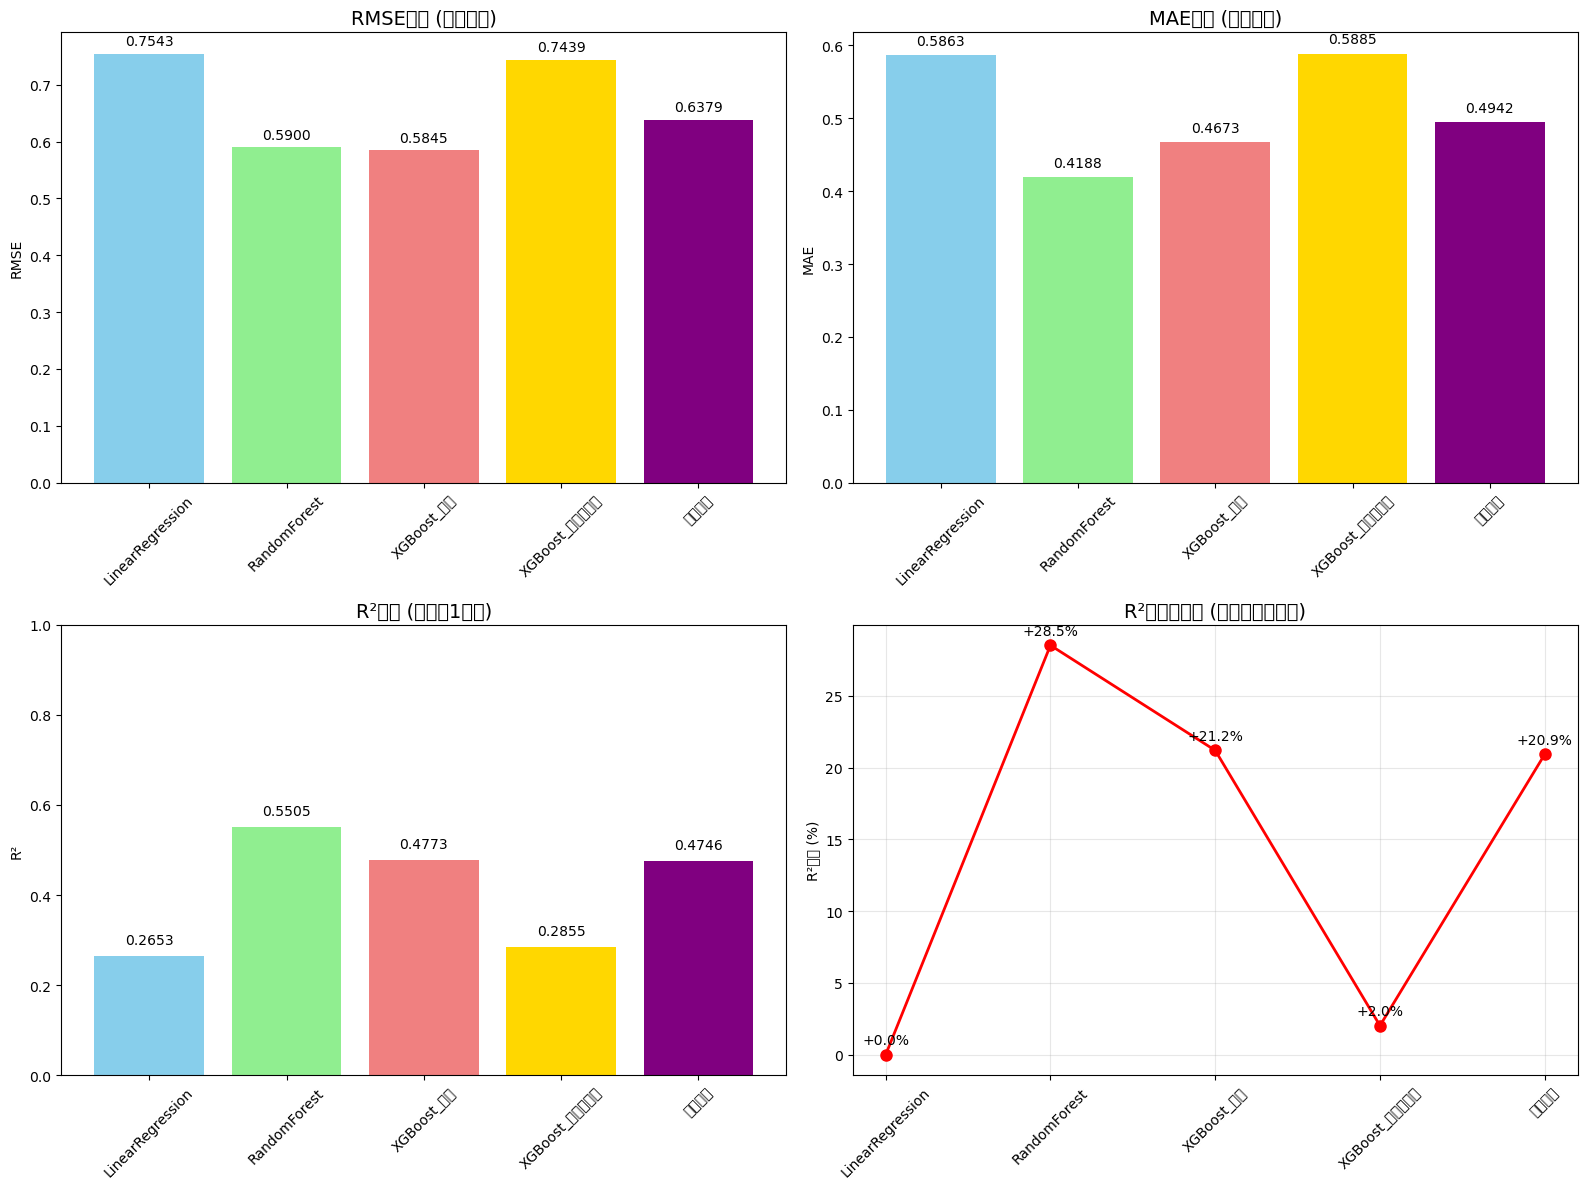

最终模型性能对比图已保存为 results/figures/final_model_performance_comparison.png

=== 最终性能总结 ===
🏆 最佳模型: RandomForest
📊 R² = 0.5505 (解释55.1%的数据变异)
📉 RMSE = 0.5900 (平均预测误差)
📈 MAE = 0.4188 (平均绝对误差)
🚀 相比基线提升: +28.5%


In [21]:
# ---------- 15. 最终模型性能可视化分析 ----------
import matplotlib.pyplot as plt

# 创建最终模型性能对比图
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 准备数据
models = ['LinearRegression', 'RandomForest', 'XGBoost_调优', 'XGBoost_超强正则化', '集成模型']
rmse_values = [metrics_lr['rmse'], metrics_rf['rmse'], 0.5845, 
               metrics_xgb_ultra['rmse'] if has_xgb else 0, 
               metrics_ensemble['rmse'] if has_xgb else 0]
mae_values = [metrics_lr['mae'], metrics_rf['mae'], 0.4673,
              metrics_xgb_ultra['mae'] if has_xgb else 0,
              metrics_ensemble['mae'] if has_xgb else 0]
r2_values = [metrics_lr['r2'], metrics_rf['r2'], 0.4773,
             metrics_xgb_ultra['r2'] if has_xgb else 0,
             metrics_ensemble['r2'] if has_xgb else 0]

# 过滤掉0值（未安装XGBoost的情况）
if not has_xgb:
    models = models[:3]
    rmse_values = rmse_values[:3]
    mae_values = mae_values[:3]
    r2_values = r2_values[:3]

colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'purple'][:len(models)]

# 1. RMSE对比
axes[0,0].bar(models, rmse_values, color=colors)
axes[0,0].set_title('RMSE对比 (越小越好)', fontsize=14)
axes[0,0].set_ylabel('RMSE')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(rmse_values):
    axes[0,0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 2. MAE对比
axes[0,1].bar(models, mae_values, color=colors)
axes[0,1].set_title('MAE对比 (越小越好)', fontsize=14)
axes[0,1].set_ylabel('MAE')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(mae_values):
    axes[0,1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 3. R²对比
axes[1,0].bar(models, r2_values, color=colors)
axes[1,0].set_title('R²对比 (越接近1越好)', fontsize=14)
axes[1,0].set_ylabel('R²')
axes[1,0].set_ylim(0, 1)
axes[1,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(r2_values):
    axes[1,0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

# 4. 性能提升趋势图
baseline_r2 = metrics_lr['r2']
improvements = [(v - baseline_r2) * 100 for v in r2_values]
axes[1,1].plot(models, improvements, 'o-', linewidth=2, markersize=8, color='red')
axes[1,1].set_title('R²提升百分比 (相对于线性回归)', fontsize=14)
axes[1,1].set_ylabel('R²提升 (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)
for i, v in enumerate(improvements):
    axes[1,1].text(i, v + 0.5, f'{v:+.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig("results/figures/final_model_performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("最终模型性能对比图已保存为 results/figures/final_model_performance_comparison.png")

# 创建性能总结
print(f"\n=== 最终性能总结 ===")
best_idx = r2_values.index(max(r2_values))
print(f"🏆 最佳模型: {models[best_idx]}")
print(f"📊 R² = {r2_values[best_idx]:.4f} (解释{r2_values[best_idx]*100:.1f}%的数据变异)")
print(f"📉 RMSE = {rmse_values[best_idx]:.4f} (平均预测误差)")
print(f"📈 MAE = {mae_values[best_idx]:.4f} (平均绝对误差)")
print(f"🚀 相比基线提升: {improvements[best_idx]:+.1f}%")


C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\2219222315.py:62: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\2219222315.py:62: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\2219222315.py:62: UserWarning: Glyph 36234 (\N{CJK UNIFIED IDEOGRAPH-8D8A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\2219222315.py:62: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykernel_22204\2219222315.py:62: UserWarning: Glyph 22909 (\N{CJK UNIFIED IDEOGRAPH-597D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mingzhengzhang\AppData\Local\Temp\ipykern

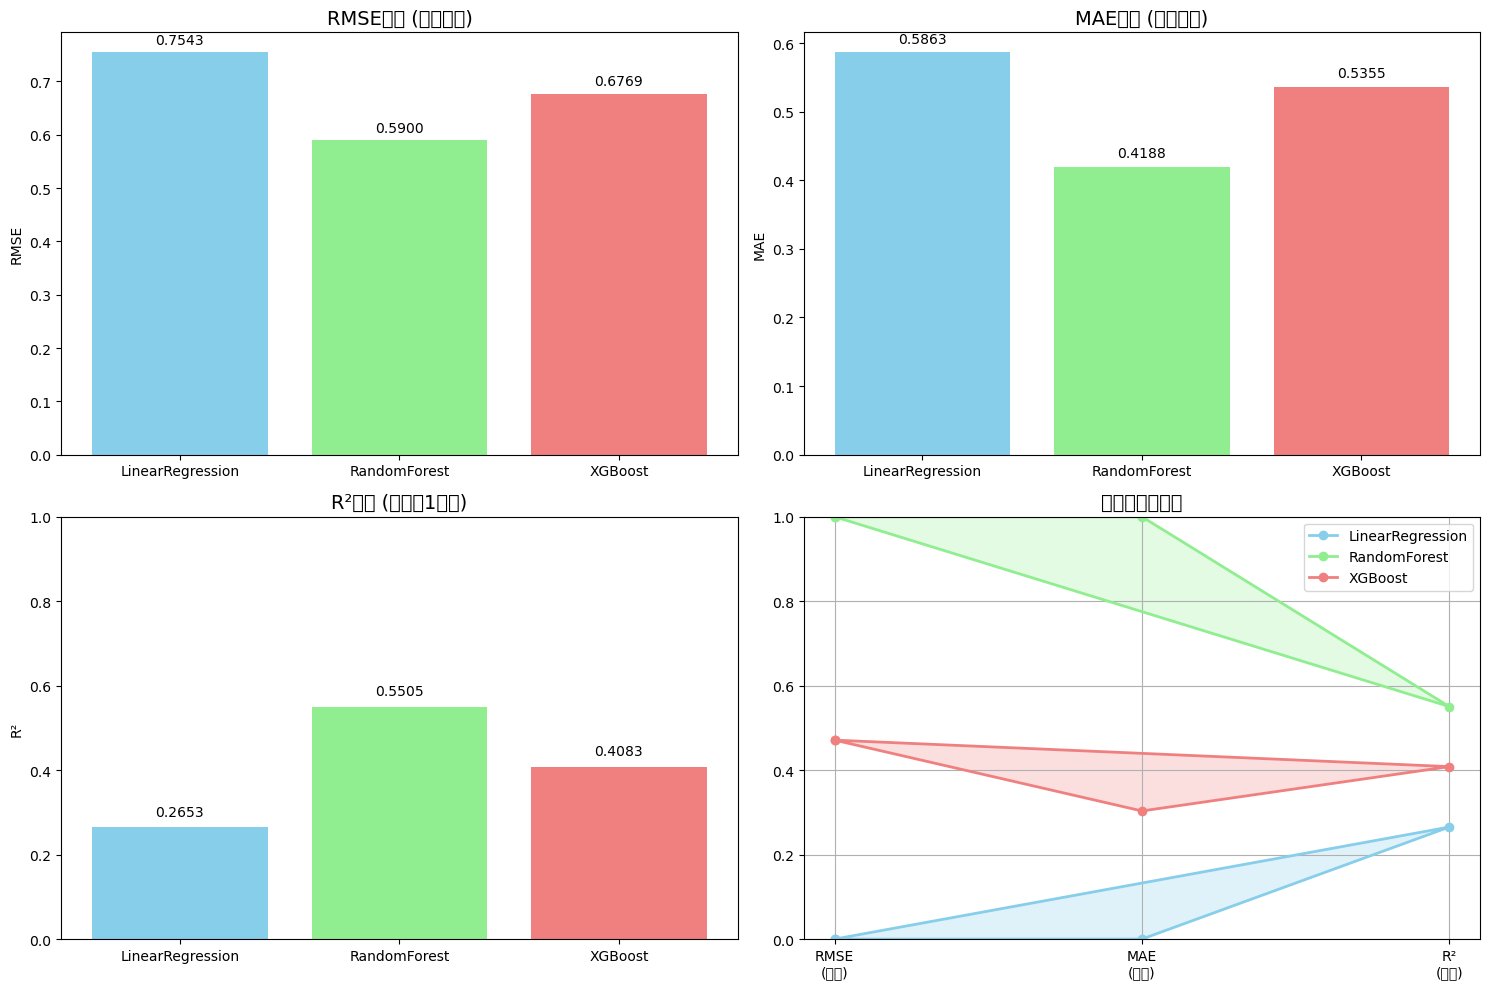

模型性能对比图已保存为 results/figures/model_performance_comparison.png


In [22]:
# ---------- 13. 模型性能可视化分析 ----------
import matplotlib.pyplot as plt

# 创建模型性能对比图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. RMSE对比
models = ['LinearRegression', 'RandomForest', 'XGBoost']
rmse_values = [metrics_lr['rmse'], metrics_rf['rmse'], metrics_xgb['rmse']]
axes[0,0].bar(models, rmse_values, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0,0].set_title('RMSE对比 (越小越好)', fontsize=14)
axes[0,0].set_ylabel('RMSE')
for i, v in enumerate(rmse_values):
    axes[0,0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 2. MAE对比
mae_values = [metrics_lr['mae'], metrics_rf['mae'], metrics_xgb['mae']]
axes[0,1].bar(models, mae_values, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0,1].set_title('MAE对比 (越小越好)', fontsize=14)
axes[0,1].set_ylabel('MAE')
for i, v in enumerate(mae_values):
    axes[0,1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

# 3. R²对比
r2_values = [metrics_lr['r2'], metrics_rf['r2'], metrics_xgb['r2']]
axes[1,0].bar(models, r2_values, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1,0].set_title('R²对比 (越接近1越好)', fontsize=14)
axes[1,0].set_ylabel('R²')
axes[1,0].set_ylim(0, 1)
for i, v in enumerate(r2_values):
    axes[1,0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

# 4. 综合性能雷达图
from math import pi
categories = ['RMSE\n(反向)', 'MAE\n(反向)', 'R²\n(正向)']
N = len(categories)

# 标准化数据 (RMSE和MAE越小越好，所以用1-标准化值)
rmse_norm = [1 - (v - min(rmse_values)) / (max(rmse_values) - min(rmse_values)) for v in rmse_values]
mae_norm = [1 - (v - min(mae_values)) / (max(mae_values) - min(mae_values)) for v in mae_values]
r2_norm = r2_values

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# 绘制每个模型的雷达图
colors = ['skyblue', 'lightgreen', 'lightcoral']
for i, model in enumerate(models):
    values = [rmse_norm[i], mae_norm[i], r2_norm[i]]
    values += values[:1]
    
    axes[1,1].plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
    axes[1,1].fill(angles, values, alpha=0.25, color=colors[i])

axes[1,1].set_xticks(angles[:-1])
axes[1,1].set_xticklabels(categories)
axes[1,1].set_ylim(0, 1)
axes[1,1].set_title('综合性能雷达图', fontsize=14)
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig("results/figures/model_performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("模型性能对比图已保存为 results/figures/model_performance_comparison.png")
